# Visualizing Data Collected using the CARLA Simulator

In [1]:
%matplotlib inline

import cv2
import matplotlib.pyplot as plt
import numpy as np

import random

In [2]:
RGB_NAME = 'C:/Users/Lenovo/Documents/SDC_PlayGround/DataCollectUbuntu/CameraRGB/1.npy'        # RGB image data
SEMSEG_NAME = 'C:/Users/Lenovo/Documents/SDC_PlayGround/DataCollectUbuntu/CameraSemSeg/1.npy'  # semantic segmentation ground truth

# load the numpy arrays
rgbs = np.load(RGB_NAME)
sems = np.load(SEMSEG_NAME)

print(f'Shapes: RGB: {rgbs.shape}, Semantic segmentation ground truth: {sems.shape}')
print(f'Data types: RGB: {rgbs.dtype}, Semantic segmentation ground truth: {sems.dtype}')

assert rgbs.shape[1:] == (240, 320, 3)  # the RGB images should be HEIGHT x WIDTH x 3 in shape
assert sems.shape[1:] == (240, 320, 1)  # the sematic segmentation ground truth should be the same shape as the depth maps
                                        # note that HEIGHT and WIDTH are defined in `mc_buffered_save.py` as
                                        # WINDOW_WIDTH and WINDOW_HEIGHT respectively

assert rgbs.dtype == np.uint8  # the RGB images have 8-bit pixel values
assert sems.dtype == np.uint8  # the semantic segmentation ground truth only has 14 distinct values, so 8-bit ints are enough

Shapes: RGB: (898, 240, 320, 3), Semantic segmentation ground truth: (898, 240, 320, 1)
Data types: RGB: uint8, Semantic segmentation ground truth: uint8


For the sanity check, we will plot 16 randomly selected but corresponding images from each of the two categories.

In [3]:
# choose 16 numbers between 0 and 999 to choose 16 images to display (note that the last arrays in any episode
# will have less than 1000 images, so modify the call to `random.randint` accordingly)
indices = random.sample(range(0, 898), 16)

def plot_16(arr, indices, sensor_name, fig_title=None):
    """Plot 16 images in `arr` with the indices in `indices`.
    `sensor_name` is one of 'rgb' and 'semseg', describing the type of sensor data.
    """
    h, w, num_channels = arr.shape[1:]
    display_array = np.empty(shape=(4 * h, 4 * w, num_channels),
                             dtype=arr.dtype)
    for r in range(4):
        for c in range(4):
            display_array[r * h: (r + 1) * h,
                          c * w: (c + 1) * w] = arr[indices[c + 4*r]]
    
    plt.figure(figsize=(16, 12))
    if fig_title is not None:
        plt.title(fig_title)
    
    if sensor_name == 'rgb':
        display_array = cv2.cvtColor(display_array, cv2.COLOR_BGR2RGB)  # convert images from BGR to RGB using opencv
        plt.imshow(display_array, aspect='auto')
    elif sensor_name == 'semseg':
        plt.imshow(display_array[:, :, 0], cmap='tab20', aspect='auto')
        plt.colorbar()
    else:
        raise ValueError(f'Unsupported sensor type {sensor_name}')
    
    plt.show()

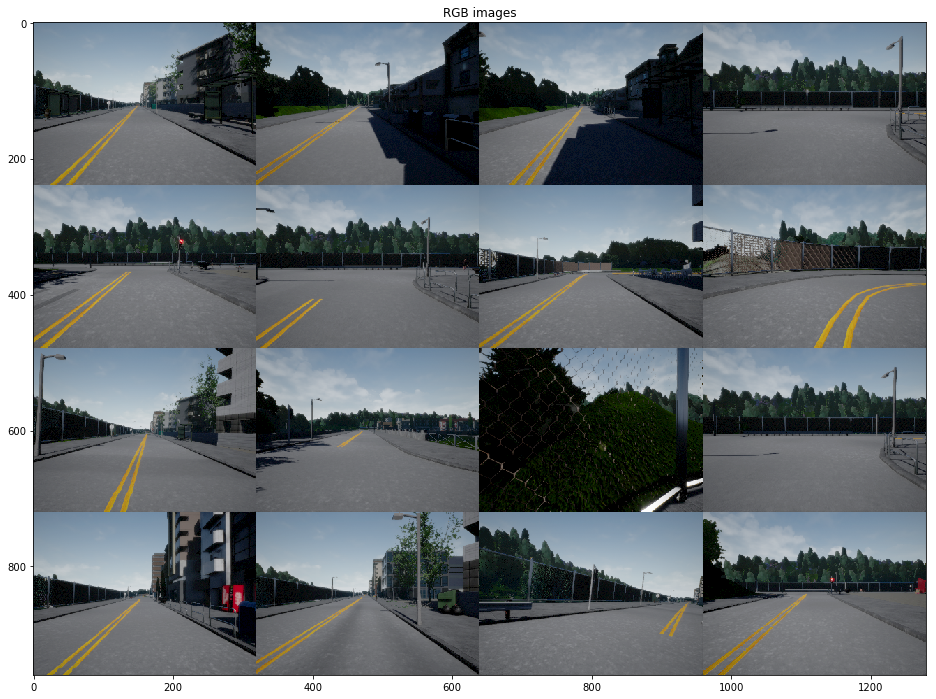

In [4]:
plot_16(rgbs, indices, 'rgb', 'RGB images')

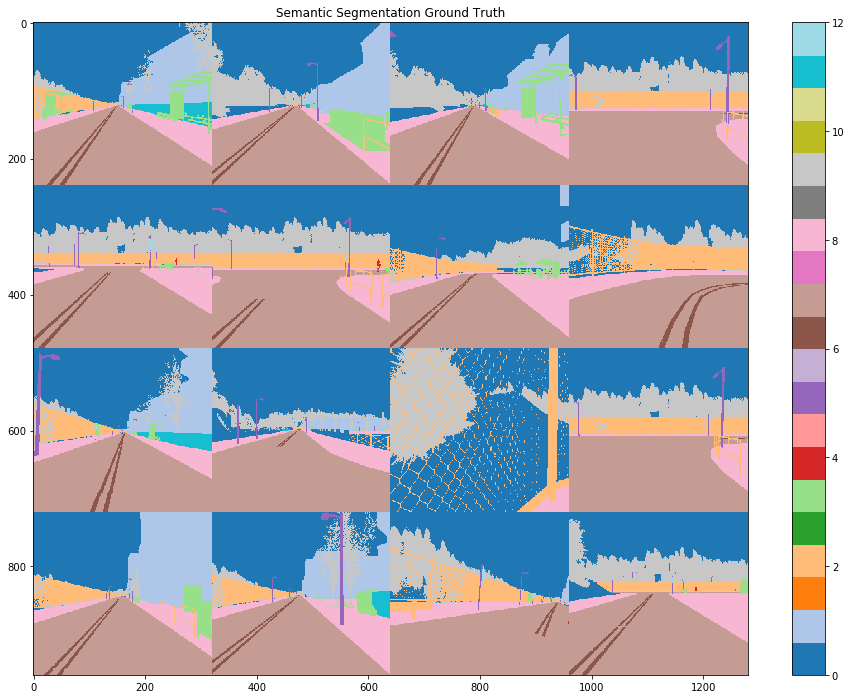

In [5]:
plot_16(sems, indices, 'semseg', 'Semantic Segmentation Ground Truth')

In [6]:
# to know what the labels mean, see:
# https://carla.readthedocs.io/en/0.8.4/cameras_and_sensors/#camera-semantic-segmentation
cmap = {
    0: np.array([0, 0, 0], dtype=np.uint8),
    1: np.array([0, 127, 180], dtype=np.uint8),
    2: np.array([127, 40, 127], dtype=np.uint8),
    3: np.array([80, 180, 80], dtype=np.uint8),
    4: np.array([255, 127, 127], dtype=np.uint8),
    5: np.array([180, 180, 180], dtype=np.uint8),
    6: np.array([255, 180, 0], dtype=np.uint8),
    7: np.array([255, 255, 0], dtype=np.uint8),
    8: np.array([255, 0, 255], dtype=np.uint8),
    9: np.array([0, 255, 0,], dtype=np.uint8),
    10: np.array([0, 0, 255], dtype=np.uint8),
    11: np.array([127, 40, 127], dtype=np.uint8),
    12: np.array([255, 0, 0], dtype=np.uint8)
}

def map_semseg_colors(ss, cmap):
    result = np.empty(list(ss.shape[:2])+[3], np.uint8)
    for r in range(ss.shape[0]):
        for c in range(ss.shape[1]):
            result[r, c] = cmap[ss[r, c, 0]]
    return result

In [7]:
from PIL import Image

indices = range(550, 550+16)
def plot_16(arr, indices):
    """Plot 16 images in `arr` with the indices in `indices`.
    `sensor_name` is one of 'rgb', 'depth', 'semseg', describing the type of sensor data.
    """
    h, w, num_channels = arr.shape[1:]
    display_array = np.empty(shape=(4 * h, 4 * w, num_channels),
                             dtype=arr.dtype)
    for r in range(4):
        for c in range(4):
            display_array[r * h: (r + 1) * h,
                          c * w: (c + 1) * w] = arr[indices[c + 4*r]]
    
    return display_array

rr = Image.fromarray(cv2.cvtColor(plot_16(rgbs, indices), cv2.COLOR_BGR2RGB), 'RGB')
ss = Image.fromarray(map_semseg_colors(plot_16(sems, indices), cmap), 'RGB')

In [8]:
rr.save('carla_rgb.png')
ss.save('carla_semseg.png')

In order to ensure that semantic segmentation ground truth matches RGB images, you need to run the simulator in `synchronous mode`! Use the following command to start the server:
```
CarlaUE4 -carla-server -benchmark -fps=20  # adjust `fps` based on your hardware
```

And don't forget to set `SynchronousMode=True` in the `CarlaSettings` object!
Here's that code:
```python
settings = CarlaSettings()
settings.set(
    SynchronousMode=True,
    SendNonPlayerAgentsInfo=True,
    NumberOfVehicles=5,
    NumberOfPedestrians=30,
    WeatherId=random.choice(list(range(15))),
    QualityLevel=args.quality_level)
```

## Comparison images
A little code to plot RGB camera images alongside their semantic segmentation ground truth versions.

In [9]:
def make_rgb_and_ss_4(rgbs, sems, indices) -> np.ndarray:
    h, w, num_channels = rgbs.shape[1:]
    result = np.empty((4 * h, 4 * w, 3), dtype=np.uint8)
    
    # plot the RGB images
    for c in range(4):
        result[0    : h,
               c * w: (c + 1) * w] = cv2.cvtColor(rgbs[indices[c]], cv2.COLOR_BGR2RGB)
    
    # plot the semantic segmentation ground truth
    for c in range(4):
        result[h    : 2 * h,
               c * w: (c + 1) * w] = map_semseg_colors(sems[indices[c]], cmap)
        
    # plot the RGB images
    for c in range(4):
        result[2 * h: 3 * h,
               c * w: (c + 1) * w] = cv2.cvtColor(rgbs[indices[c + 4]], cv2.COLOR_BGR2RGB)
    
    # plot the semantic segmentation ground truth
    for c in range(4):
        result[3 * h: 4 * h,
               c * w: (c + 1) * w] = map_semseg_colors(sems[indices[c + 4]], cmap)
    
    return result 

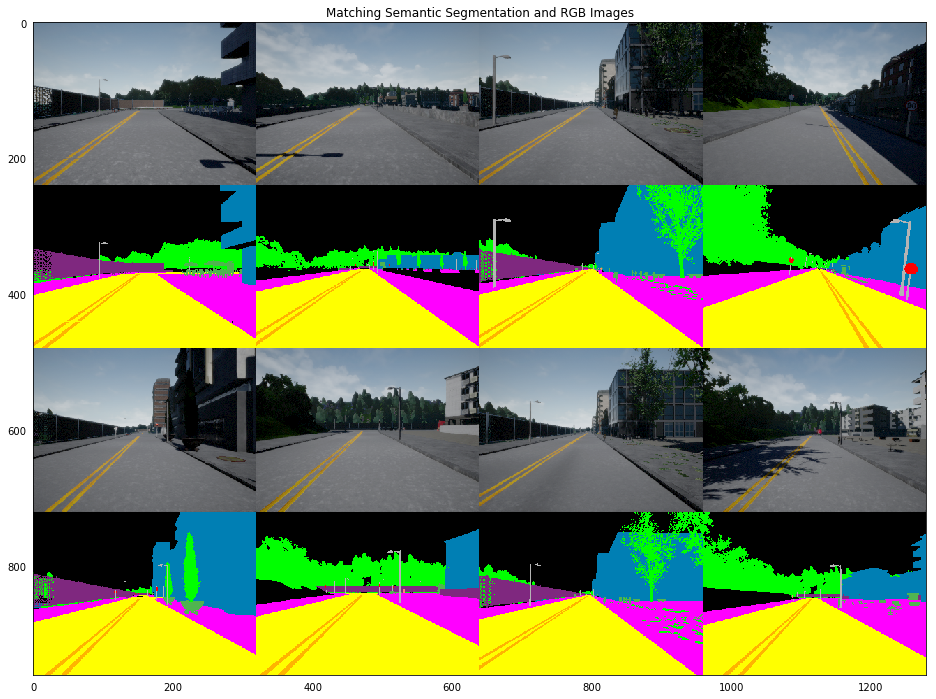

In [10]:
juxtaposed_rgb_and_semseg = make_rgb_and_ss_4(rgbs, sems, random.sample(range(672), 8))

plt.figure(figsize=(16, 12))
plt.imshow(juxtaposed_rgb_and_semseg, aspect='auto')
plt.title('Matching Semantic Segmentation and RGB Images')
plt.tick_params(axis='both',
                bottom=False,
                left=False)
plt.show()

In [11]:
juxta_good = Image.fromarray(juxtaposed_rgb_and_semseg, 'RGB')
juxta_good.save('good_juxtaposed.png')